<a href="https://colab.research.google.com/github/nvinogradskaya/DL_HW4_RNN/blob/main/LSTM%2BContrastive3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Concatenate, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json

In [2]:
from google.colab import drive
SEQ_LENGTH = 10
EMBEDDING_DIM = 16
LSTM_UNITS = 64
BATCH_SIZE = 64
EPOCHS = 10
TEST_SIZE = 0.2
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Data/"
SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/contrastive_results3/"
SEQ_SAVE_PATH = os.path.join(SAVE_PATH, 'sequences/')
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

Mounted at /content/drive


In [35]:
def load_and_preprocess_data(data_path, max_users=100, max_files_per_user=30):  # <- Добавлено
    data = []
    user_dirs = sorted(os.listdir(data_path))[:max_users]

    for user in user_dirs:
        traj_dir = os.path.join(data_path, user, 'Trajectory')
        traj_files = sorted([f for f in os.listdir(traj_dir) if f.endswith('.plt')])[:max_files_per_user]  # <- Ограничение

        for traj_file in traj_files:
            df = pd.read_csv(
                os.path.join(traj_dir, traj_file),
                skiprows=6,
                header=None,
                usecols=[0, 1, 3, 5, 6],
                names=['lat', 'lon', 'alt', 'date', 'time']
            )
            df['user'] = user
            data.append(df)

    df = pd.concat(data, ignore_index=True)
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    df.sort_values(by=['user', 'datetime'], inplace=True)
    df = df[(df['lat'] != 0) & (df['lon'] != 0)].ffill()

    scaler = MinMaxScaler()
    df[['lat', 'lon', 'alt']] = scaler.fit_transform(df[['lat', 'lon', 'alt']])

    df['hour_sin'] = np.sin(2 * np.pi * df['datetime'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['datetime'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['datetime'].dt.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['datetime'].dt.dayofweek / 7)

    user_ids = {user: idx for idx, user in enumerate(df['user'].unique())}
    df['user_id'] = df['user'].map(user_ids)

    return df, user_ids, scaler

In [36]:
df, user_ids, scaler = load_and_preprocess_data(DATA_PATH, max_users=100, max_files_per_user=10)

In [37]:
def create_sequences_and_save(df, user_ids, seq_length, test_size=0.2, save_path='./seq_data'):
    os.makedirs(save_path, exist_ok=True)
    features = ['lat', 'lon', 'alt', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
    targets = ['lat', 'lon']

    for user, user_df in df.groupby('user'):
        uid = user_ids[user]
        user_df = user_df.reset_index(drop=True)
        split_idx = int(len(user_df) * (1 - test_size))
        if split_idx <= seq_length:
            continue

        def process_chunk(data, is_train=True):
            window_size = seq_length + 1
            data_values = data[features].values

            # Проверка на достаточность данных
            if len(data_values) < window_size:
                print(f"Недостаточно данных для пользователя {uid}. Пропуск.")
                return [], []

            # Создание окон и удаление лишней оси
            X = np.lib.stride_tricks.sliding_window_view(data_values, (window_size, data_values.shape[1]))
            X = X.squeeze(axis=1)  # Удаляем ось с размером 1
            X = X[:, :-1]  # Форма: (N, seq_length, features)
            y = data[targets].values[seq_length:]

            # Сохранение чанков
            chunk_size = 1000
            for i in range(0, len(X), chunk_size):
                save_chunk(X[i:i+chunk_size], y[i:i+chunk_size], is_train)

            return [], []

        def save_chunk(X, y, is_train):
            suffix = 'train' if is_train else 'test'
            chunk_id = uuid.uuid4().hex
            np.savez_compressed(
                os.path.join(save_path, f'user_{uid}_{suffix}_{chunk_id}.npz'),
                X=X,
                y=y
            )

        process_chunk(user_df.iloc[:split_idx], is_train=True)
        process_chunk(user_df.iloc[split_idx-seq_length:], is_train=False)

In [38]:
import shutil
shutil.rmtree(SEQ_SAVE_PATH)
os.makedirs(SEQ_SAVE_PATH, exist_ok=True)

In [39]:
import uuid
create_sequences_and_save(df, user_ids, SEQ_LENGTH, save_path=SEQ_SAVE_PATH)

In [40]:
def load_all_sequences_from_disk(save_path):
    X_train, X_test, y_train, y_test, users_train, users_test = [], [], [], [], [], []

    for fname in sorted(os.listdir(save_path)):
        if not fname.endswith('.npz'):
            continue

        # Определяем тип данных (train/test) из имени файла
        if 'train' in fname:
            split_type = 'train'
        elif 'test' in fname:
            split_type = 'test'
        else:
            continue  # Пропускаем файлы без указания типа

        # Извлекаем user_id из имени файла (формат: user_{uid}_{split}_...)
        uid = int(fname.split('_')[1])

        data = np.load(os.path.join(save_path, fname))

        # Загружаем данные с новыми ключами 'X' и 'y'
        X = data['X']
        y = data['y']

        # Добавляем в соответствующие списки
        if split_type == 'train':
            X_train.append(X)
            y_train.append(y)
            users_train.append(np.full(len(X), uid))
        else:
            X_test.append(X)
            y_test.append(y)
            users_test.append(np.full(len(X), uid))

    # Конкатенация данных
    return (
        np.concatenate(X_train), np.concatenate(X_test),
        np.concatenate(y_train), np.concatenate(y_test),
        np.concatenate(users_train), np.concatenate(users_test)
    )

In [41]:
X_train, X_test, y_train, y_test, users_train, users_test = load_all_sequences_from_disk(SEQ_SAVE_PATH)
print("X_train shape:", X_train.shape)  # Должно быть (N, SEQ_LENGTH, features)

X_train shape: (53942, 10, 7)


In [42]:
class ContrastiveModel(tf.keras.Model):
    def __init__(self, num_users, embedding_dim):
        super().__init__()
        self.embedding = Embedding(num_users, embedding_dim)
        self.dense = Dense(embedding_dim, activation='tanh')

    def call(self, inputs):
        user_id = inputs
        user_emb = self.embedding(user_id)
        return self.dense(user_emb)

    def train_step(self, data):
        users, _ = data  # Игнорируем метки, так как они фиктивные
        with tf.GradientTape() as tape:
            embeddings = self(users)

            # Генерируем пары (anchor, positive) внутри батча
            anchor = embeddings[:-1]  # Все, кроме последнего
            positive = embeddings[1:]  # Все, кроме первого

            # Вычисляем контрастную потерю
            distances = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
            loss = self.compiled_loss(tf.zeros_like(distances), distances)  # Фиктивные метки

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss': loss}

In [43]:
contrastive_model = ContrastiveModel(num_users=len(user_ids), embedding_dim=EMBEDDING_DIM)
contrastive_model.compile(optimizer=Adam(0.001), loss=tf.keras.losses.MeanSquaredError())
contrastive_model.fit(users_train, np.zeros(len(users_train)), epochs=5, batch_size=BATCH_SIZE)
user_embeddings = contrastive_model.predict(np.unique(users_train))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:667: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4737e-06
Epoch 2/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.6893e-10
Epoch 3/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3779e-10
Epoch 4/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0276e-10
Epoch 5/5
843/843 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.5864e-11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [44]:
print("X_train shape:", X_train.shape)  # Должно быть (N, SEQ_LENGTH, features)

X_train shape: (53942, 10, 7)


In [45]:
def combine_features(X, users, embeddings):
    # Проверка и коррекция размерности
    if X.ndim == 4 and X.shape[1] == 1:
        X = X.squeeze(axis=1)  # Удаляем ось с размером 1
    elif X.ndim != 3:
        raise ValueError(f"Некорректная размерность X: {X.shape}. Ожидается (N, seq_len, features).")

    # Получение эмбеддингов и их расширение
    user_embs = embeddings[users]  # Форма: (N, embedding_dim)
    embeddings_expanded = np.repeat(user_embs[:, np.newaxis, :], SEQ_LENGTH, axis=1)  # (N, seq_len, embedding_dim)

    # Объединение данных
    combined = np.concatenate([X, embeddings_expanded], axis=-1)
    print(f"X shape: {X.shape}, embeddings_expanded shape: {embeddings_expanded.shape}, combined shape: {combined.shape}")
    return combined

X_train_combined = combine_features(X_train, users_train, user_embeddings)
X_test_combined = combine_features(X_test, users_test, user_embeddings)

X shape: (53942, 10, 7), embeddings_expanded shape: (53942, 10, 16), combined shape: (53942, 10, 23)
X shape: (13501, 10, 7), embeddings_expanded shape: (13501, 10, 16), combined shape: (13501, 10, 23)


In [46]:
def build_lstm_model(seq_length, embedding_dim, num_features, num_users):
    seq_input = Input(shape=(seq_length, num_features))
    user_input = Input(shape=(1,), dtype=tf.int32)

    user_emb = Embedding(num_users, embedding_dim)(user_input)
    user_emb = Reshape((embedding_dim,))(user_emb)

    lstm_out = LSTM(LSTM_UNITS, return_sequences=False)(seq_input)
    combined = Concatenate()([lstm_out, user_emb])

    dense_out = Dense(64, activation='relu')(combined)
    dense_out = Dense(32, activation='relu')(dense_out)
    final_output = Dense(2, activation='linear')(dense_out)

    model = Model(inputs=[seq_input, user_input], outputs=final_output)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

In [47]:
def sequence_generator(file_list, batch_size, seq_length, embedding_matrix):
    def generator():
        for file in file_list:
            data = np.load(file)
            X = data['X_train']
            y = data['y_train']
            user_id = data['user_id']
            emb = embedding_matrix[user_id]
            emb_expanded = np.repeat(emb[np.newaxis, :], seq_length, axis=0)

            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                u_batch = np.array([user_id] * len(X_batch))
                emb_batch = np.repeat(emb[np.newaxis, :], len(X_batch) * seq_length, axis=0).reshape(len(X_batch), seq_length, -1)
                yield (np.concatenate([X_batch, emb_batch], axis=-1), u_batch), y_batch
    return generator

In [48]:
def create_dataset_from_generator(npz_folder, batch_size, seq_length, embedding_matrix, split='train'):
    file_list = sorted([os.path.join(npz_folder, f) for f in os.listdir(npz_folder) if f.endswith('.npz')])

    def dataset_gen():
        for file in file_list:
            data = np.load(file)
            X = data[f'X_{split}']
            y = data[f'y_{split}']
            user_id = data['user_id']
            emb = embedding_matrix[user_id]
            emb_expanded = np.repeat(emb[np.newaxis, :], seq_length, axis=0)

            for i in range(0, len(X), batch_size):
                X_batch = X[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                u_batch = np.array([user_id] * len(X_batch))
                emb_batch = np.repeat(emb[np.newaxis, :], len(X_batch) * seq_length, axis=0).reshape(len(X_batch), seq_length, -1)
                yield (np.concatenate([X_batch, emb_batch], axis=-1), u_batch), y_batch

    output_signature = (
        (
            tf.TensorSpec(shape=(None, seq_length, X.shape[2] + embedding_matrix.shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(
        dataset_gen,
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE)

In [50]:
model = build_lstm_model(SEQ_LENGTH, EMBEDDING_DIM, X_train_combined.shape[2], len(user_ids))

checkpoint = ModelCheckpoint(os.path.join(SAVE_PATH, 'best_model.h5'),
                             save_best_only=True, monitor='val_loss')

history = model.fit(
    [X_train_combined, users_train], y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint]
)

Epoch 1/5
670/675 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - mae: 0.0775

675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0289 - mae: 0.0771 - val_loss: 0.0012 - val_mae: 0.0160
Epoch 2/5
670/675 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1280e-04 - mae: 0.0054

675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.1258e-04 - mae: 0.0054 - val_loss: 0.0012 - val_mae: 0.0184
Epoch 3/5
665/675 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5607e-05 - mae: 0.0051

675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.5320e-05 - mae: 0.0051 - val_loss: 9.9394e-04 - val_mae: 0.0150
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.2859e-05 - mae: 0.0048 - val_loss: 0.0010 - val_mae: 0.0154
Epoch 5/5
669/675 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.4100e-05 - mae: 0.0043

675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 6.4159e-05 - mae: 0.0043 - val_loss: 9.0865e-04 - val_mae: 0.0149


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ADE: 0.0327, FDE: 3.2767, Accuracy@1: 0.4200


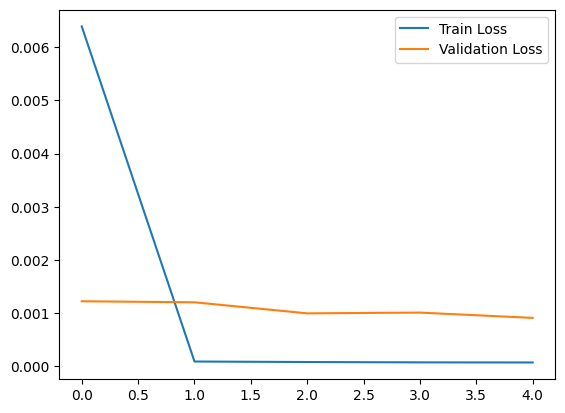

In [51]:
def calculate_metrics(preds, targets):
    ade = np.mean(np.linalg.norm(preds - targets, axis=-1))
    fde = np.linalg.norm(preds[:, -1] - targets[:, -1], axis=-1).mean()
    distances = np.linalg.norm(preds[:, None] - targets[:, :, None], axis=-1)
    acc1 = np.mean(np.argmin(distances, axis=-1) == 0)
    return ade, fde, acc1

model.load_weights(os.path.join(SAVE_PATH, 'best_model.h5'))
y_pred = model.predict([X_test_combined, users_test])

ade, fde, acc1 = calculate_metrics(y_pred, y_test)
print(f"ADE: {ade:.4f}, FDE: {fde:.4f}, Accuracy@1: {acc1:.4f}")

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()